# Project 3
In this project, I want to find out if there a way to classify if a movie is a success or not success, based on some of the features that are available. This features are:  
$x_1 \sim$ Runtime  
$x_2 \sim$ Release Year  
$x_3 \sim$ Words in title  
$x_4 \sim$ Length of title  
In this project I am characterizing a project as successful if the IMBd rating is 7 or above.  

First we load only some of the data, so that it is possible to run the code in the time span that we have(We don't have time to import all the data from the csv-files, but this would have given us a bit better results).  
We split the data into a training set and a test set. Then we also normalize the x-variables in the data, using StandardScaler in sklearn. This is because we don't want the results to be skewed or dominated by the variables that are in larger scales. It is also important to scale after we have splitted to ensure we are not breaking the golden rule of machine learning, or training on test data / test leakage.

In [1]:
import task3_methods as tm
methods = tm.Methods()

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


File found: ../title.basics.tsv
File found: ../data/title.ratings.tsv


# Bayesian and Probabilistic Modelling  

* Compute posterior probabilities for a parameter in your dataset using the Beta–Binomial model (or another simple conjugate pair).  
* Implement Bayesian regression  

Also including multi variate linear regression from Enrico methods.

### Beta–Binomial Posterior

Given:
- Prior: $ p \sim \text{Beta}(\alpha, \beta) $
- Likelihood: $ k \sim \text{Binomial}(n, p) $

The posterior is:
$$
p \mid k \sim \text{Beta}(\alpha + k,\; \beta + n - k)
$$

Posterior mean:
$$
E[p \mid k] = \frac{\alpha + k}{\alpha + \beta + n}
$$
  
The first method we are going to use is bayesian and probabalistic modelling, by using a prior distribution for the probability of a rating of 7 or above.  
*IMDb ratings*  
"IMDb registered users can give a rating (from 1 to 10) on every released title in the database. Individual ratings are then aggregated and summarized as a single IMDb rating, visible on the title's main page. By "released title" we mean that the movie (or TV series etc.) must have been shown publicly at least once (including festival screening).

Users can update their ratings as often as they'd like, but any new rating on the same title will overwrite the previous one, so it is one rating per title per user." (IMBD, 2025)  

To arrive at a prior distribution to this, we can use some common sense; If the users are giving a rating between 1 to 10, one can assume that a really terrible movie is rated 1, and the best one is rated 10. The movies are probably equally distributed between the terrible ones and the best ones, and therefore we can assume that the prior is of uniform distribution. Assuming that the ratings are given based on a uniformly distribution, we can approximate that $p_{prior} = P_{uniform}(ratings \ge 7) = \frac39=\frac13$. (Counting the intervals between the numbers. 3 between 7 and 10, and 9 in total).   
Our prior knowledge states that the probability has a beta distribution, and therefore we classify $ \frac \alpha \beta = \frac 12$. The variance that we can use for the prior is not as straightforward. We can have two different options where we assume that we are very confident on one, and less confident on another. We then have two cases.  

$$ 
\alpha_{conf} = 2000, \beta_{conf}=4000
$$
$$
\alpha_{weak} = 10, \beta_{weak} = 20
$$  

  
To clarify; my belief is not very strong, and therefore I should use a prior that is not really "confident", or in other words low $\alpha$ and $\beta$. We then find the posterior by calculating the new beta distribution.  
First we find the mean for over 7 in IMBd from the dataset, without any priors.

In [2]:
methods.print_success_rate()

Successes: 11433, Trials: 21870 and P(success)=0.523


We can see from the results that we probably missed with the $p = 0,33$, because the mean of the data is $E(p_{data})=0,53$

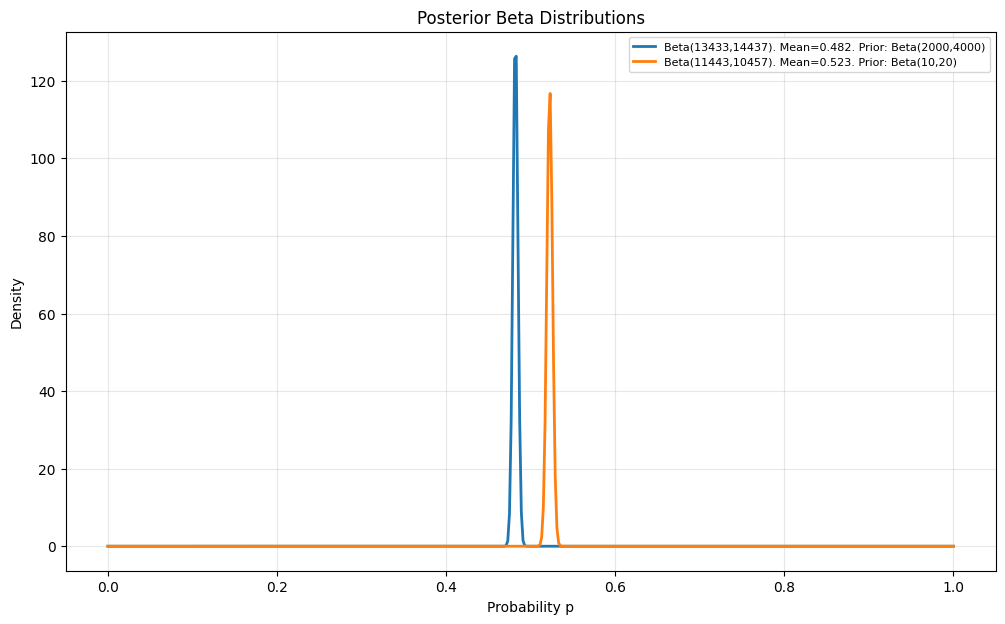

In [3]:
priors = [(2000,4000), (10,20)]


results = methods.compute_posteriors(priors=priors)
methods.plot_posteriors(results)

### Continuing to Bayesian Regression

For Bayesian regression, we need to assume prior distributions for the $\beta$ parameters. We do not have strong evidence about their values, so it does not make sense to give strong priors. Instead, we will use weak priors that don't strongly influence the posterior.

---

#### Parameters to assume:

- **$\beta_0$** (Intercept): This is the value the model would predict if all variables were zero. Since this is hard to speculate about, we assign a wide prior:

$$
\beta_0 \sim \mathcal{N}(0, 100^2)
$$

- **$\beta_1$** (Effect of runtime):  Here, we assume $\beta_1$ might be negative (longer runtime could slightly reduce success probability), but we keep the prior weak and set its mean to 0(weak prior knowledge):

$$
\beta_1 \sim \mathcal{N}(0, 10^2)
$$

- **$\beta_2$** (Release year): We expect newer movies might have slightly better success, but again, we use a weak prior:

$$
\beta_2 \sim \mathcal{N}(0, 10^2)
$$

- **$\beta_3$** (Words in title) and **$\beta_4$** (Length of title): These features likely have minimal effect, so we assume:

$$
\beta_3, \beta_4 \sim \mathcal{N}(0, 10^2)
$$



`sigma` represents the standard deviation of the observation noise in the likelihood:

$$
y \mid X, \beta, \sigma \sim \mathcal{N}(\mu, \sigma^2)
$$

This is not the variance of the coefficients; it’s the variance of the errors in $y$. Here we also use a value of $10$.

---


### Why weak priors?

Because the dataset is relatively large, the likelihood will dominate, and the posterior will mostly reflect the data. Strong priors would only make sense if we had more knowledge.


### Multivariate linear regression (frequentists approach)  
Firstly, we compute the linear regression parameters. This is the most optimal line for the lowest MSE for the training data, and is giving fixed parameters. We are also showing a plot over the parameters versus ratings, for a quick overview. 

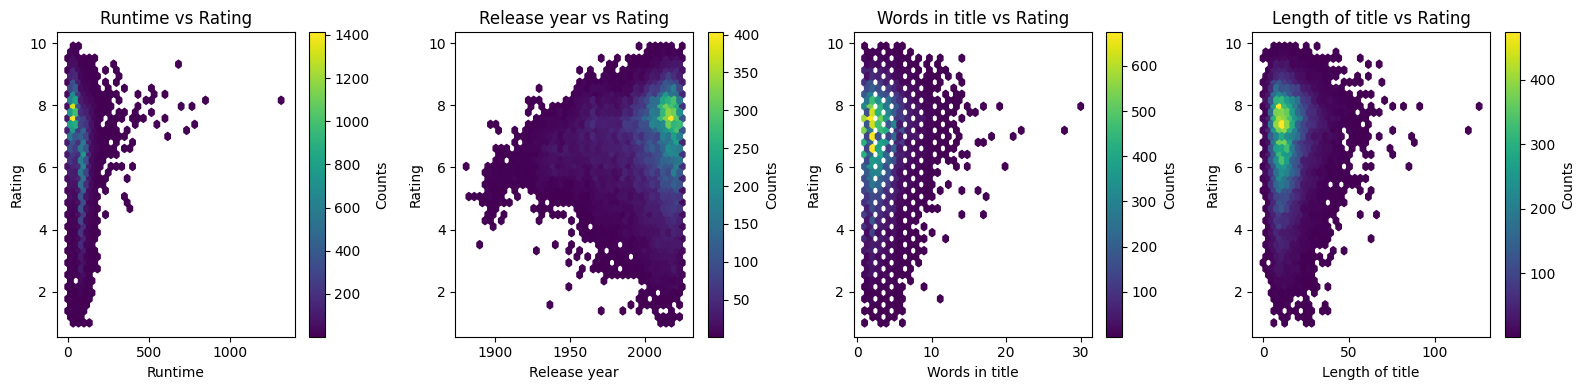

In [4]:
methods.DM.scatter_plots_features_vs_rating()

In [5]:
beta = methods.linear_regression_multivariate()
methods.compute_mse(beta)

Mean Squared Error (MSE): 1.608 for beta coefficients: [ 6.77596708 -0.45484277  0.10025413  0.13516626 -0.08192509]


This code builds a Bayesian regression model using PyMC. It starts by defining an intercept parameter $b_0$ drawn from a normal distribution with mean $0$ and standard deviation $100$. Then it defines four regression coefficients $b$ drawn from a normal distribution with mean $0$ and standard deviation $10$. The error term $\sigma$ is drawn from a half-normal distribution to ensure it is positive. The predicted values are computed as $\mu = b_0 + X_{\text{train}} \cdot b$, where $X_{\text{train}}$ represents the training predictors. The observed data $y_{\text{train}}$ is assumed to follow a normal distribution with mean $\mu$ and standard deviation $\sigma$. The model uses Sequential Monte Carlo (SMC) sampling to draw $4000$ samples from the posterior distribution of all parameters.

The output from pm.summary(trace) shows a table with the posterior estimates for $b_0$, the coefficients $b$, and $\sigma$. The mean column gives the average estimated value for each parameter, which can be interpreted as the best guess based on the data and prior assumptions.  
  
Because I was not able to run the code on my PC, I will not be able to interpret the results. I get a runtime error.

In [ ]:
methods.bayesian_regression_multivariate()

# Classification

* Implement a Support Vector Classifier with linear or RBF kernels. Compare performance metrics (accuracy, precision, recall, confusion matrix). Discuss the role of the cost function and kernel choice.  

## Performance metrics
To see how well the models worked, I look at several results:
- **Accuracy** tells us how many movies were correctly classified overall.
- **Precision** shows how many of the movies predicted as "success" actually were successful.
- **Recall** tells us how many of the actual successful movies the model managed to find.
- The **confusion matrix** gives a breakdown of correct and incorrect predictions for both classes.

### The Role of Cost Function and Kernel Choice

The cost function (often called "C" in SVC) controls how much the model tries to avoid miss classifications on the training data.  
- If C is high, the model will try very hard to classify every training point right, which can lead to overfitting (the model becomes too fitted on the training data and capturing noise and may not work well on new data).
- If C is low, the model allows more mistakes on the training data, which can help it generalize better to new data.

The kernel decides how the model draws the line (or boundary) between classes:
- The linear kernel draws a straight line (or plane) to separate the classes. It works well if the data can be separated simply.
- The RBF kernel can draw more complex, curved boundaries. It is useful when the relationship between features and the target is not just a straight line.

Choosing the right cost value and kernel is important because it affects how well the model can learn from the data and make predictions on new, unseen movies. However, if the data is linearly seperatable we will not see a large difference in performance.
## SVC with linear and RBF Kernel
I implement a support vector classifier (SVC) with linear and RBF kernels and compare performance using accuracy, precision, recall, and the confusion matrix. Creating a grid search to find the most optimal c for the linear, and c and gamma for rbf kernel

In [6]:
optimized_kernels =methods.create_grid_search()

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters for kernel linear: {'C': 1}
Best score for kernel linear: 0.7528482108120196
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters for kernel rbf: {'C': 10, 'gamma': 0.01}
Best score for kernel rbf: 0.7578477053484175


In [7]:
trained_models = methods.create_clfs(optimized_kernels)

Training - Kernel: linear
Training - Kernel: rbf


Evaluation Metrics for Kernel: linear:
Accuracy: 0.7752
Precision: 0.7926
Recall: 0.7740


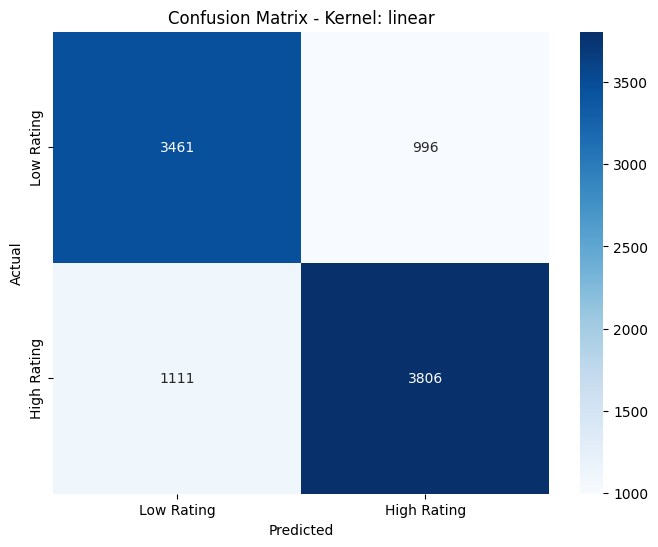

Evaluation Metrics for Kernel: rbf:
Accuracy: 0.7786
Precision: 0.8066
Recall: 0.7602


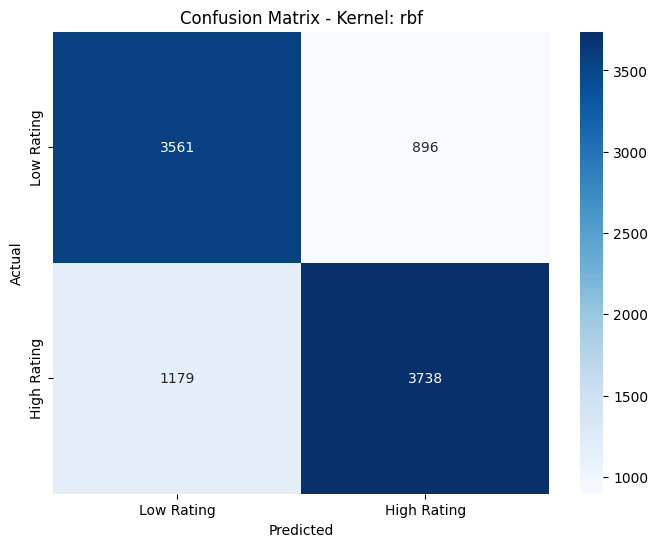

In [8]:
methods.evaluate_models(trained_models)

## Multivariate linear regression  
Here I found it interesting in seeing how the multivariate linear regression model that I made earlier would be doing, if we counted each value that the model predicted as over 7 as success.

Evaluation Metrics for Multivariate Linear Regression Predictor:
Accuracy: 0.7148
Precision: 0.8029
Recall: 0.6048


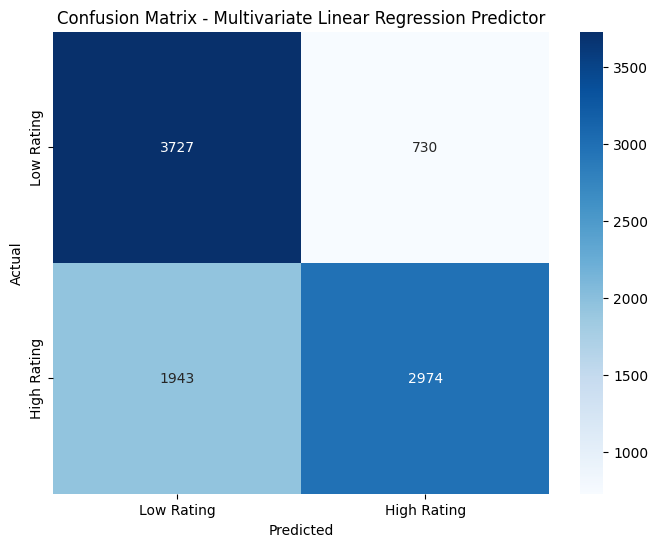

In [9]:
y_pred_reg_test = methods.predict_multivariate()
y_pred_test = (y_pred_reg_test >= 7).astype(int)
evaluation_test = methods.eval_parameters(y_pred=y_pred_test, y_true=methods.y_test_bin)
methods.print_evaluation(*evaluation_test, name="Multivariate Linear Regression Predictor")

## Neural Network Classification  

In this project, we use a neural network to classify whether a movie is a "success" (IMDb rating of 7 or higher). This method evaluates the neural network with different activation functions (ReLU and logistic), a specific hidden layer structure. I chose a (64,32) structure because this is the layers that performed the best in task 2. 

Evaluation Metrics for Neural Network Classifier (relu activation):
Accuracy: 0.7893
Precision: 0.8049
Recall: 0.7897


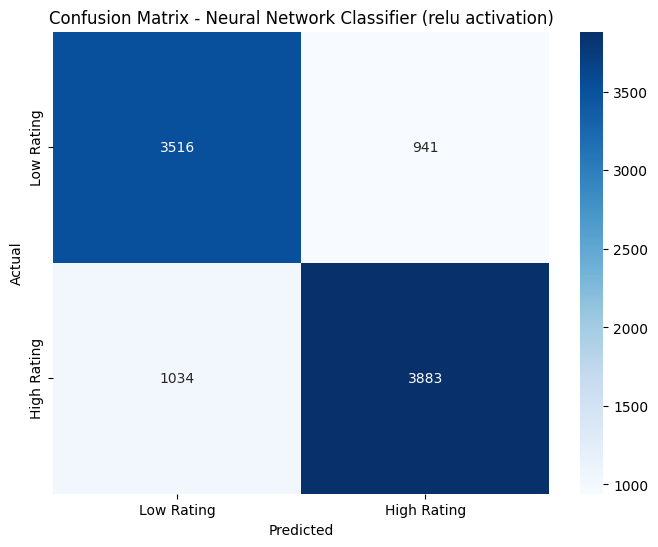

Evaluation Metrics for Neural Network Classifier (logistic activation):
Accuracy: 0.7898
Precision: 0.8082
Recall: 0.7858


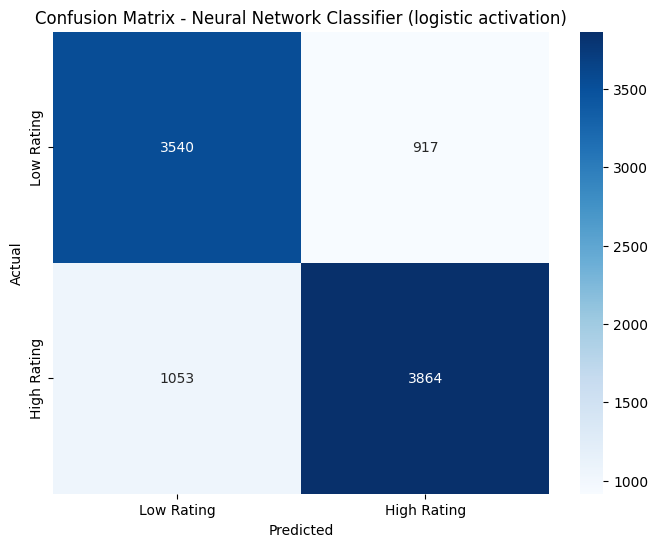

In [10]:
activation_functions = ['relu', 'logistic']
methods.nn_evalution(activation_functions, hidden_layers=(64, 32), solver='adam')

## Discussion of Classification Results

In this project, I tried to predict if a movie would be a "success" (meaning an IMDb rating of 7 or higher) using features like runtime, release year, number of words in the title, and title length. I used different machine learning models, including Support Vector Classifiers (SVC) with both linear and RBF kernels, as well as a linear regression model and a neural network.


The linear SVC is good when the data is simple and can be separated with a straight line, while the RBF SVC can handle more complex patterns. The neural network can also find complex patterns if there is enough data, but it can be harder to train and understand.

If a model has high accuracy, precision, and recall, it means it is doing a good job. Sometimes, a model might have high precision but lower recall, which means it is careful about calling a movie a success but might miss some successful movies. If recall is high but precision is low, the model finds most successful movies but also makes more mistakes.

Choosing the right model and settings (like the kernel type and cost parameter) is important. The best model is the one that balances these results well, depending on what is most important for the task. For example, if it is more important to find all successful movies, recall matters more. Overall, the results show that using different models and checking several metrics gives a better understanding of how well the classification works.

Comparing the results we see that there is not much of a difference. This might be because the data is linearly seperatable, and there are no need for the rbf kernel and NN-classification. The multivariate linear regression is the worst one, because this is not fitted for classification but rather minimizing the MSE. The model that gives highest accuracy and in general high characteristics parameters is the NN-model with the logistics activation function, right before the relu-activation function.

# References  
IMDB. (n.d) Retrieved from: https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#